In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation 
from pyts.image import MarkovTransitionField
import dask.dataframe as dd  
import pandas as pd


from scipy import signal as sign
from PIL import Image
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [ ]:
ddf = dd.read_parquet("dataset/train.parquet", engine="pyarrow")
df_metadata = pd.read_csv('dataset/metadata_train.csv')

In [ ]:
signal = ddf["706"].compute()

fs = 8e5/20e-3

f, t, Sxx = sign.spectrogram(signal, fs)

print(f.shape, t.shape, Sxx.shape)

plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()


In [ ]:
from PIL import Image
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,255))
Sxx = scaler.fit_transform(Sxx)

img = Image.fromarray(Sxx).resize((1024, 768))


plt.imshow(img)
img = np.array(img)
img

In [ ]:
len(ddf.columns)

In [ ]:
from tqdm import tqdm
images = []
fs = 8e5/20e-3 # Sampling frequency
img_size = 256, 256 # Size for all images 


for col in tqdm(ddf.columns):
    # Get signal
    signal = ddf[str(col)].compute()

    # Get spectrogram from signal
    f, t, Sxx = sign.spectrogram(signal, fs)
    # Transform spectrogram to image range (0, 255)
    scaler = MinMaxScaler(feature_range=(0,255))
    Sxx = scaler.fit_transform(Sxx)
    # Resize image
    img = np.array(Image.fromarray(Sxx).resize(img_size))
    images.append(img)
    
images = np.array(images).reshape((len(ddf.columns), 256, 256, 1))

In [ ]:
np.save("dataset/images.npy", images)

In [ ]:
labels = df_metadata[["target"]]
np.save("dataset/labels.npy", labels)
print(labels)
labels.shape

In [ ]:
%matplotlib notebook
n_signal = 0
fig = plt.figure() # make figure
im = plt.imshow(images[0], cmap='gray')

# function to update figure
def updatefig(j):
    # set the data in the axesimage object
    im.set_array(images[j])
    fig.suptitle(str(j))
    # return the artists set
    return [im]
# kick off the animation
ani = animation.FuncAnimation(fig, updatefig, 
                              interval=10, blit=True)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

X_data, X_test, y_data, y_test = train_test_split(images, labels, test_size=0.3, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

np.save("dataset/train/images_train.npy", X_train)
np.save("dataset/train/labels_train.npy", y_train)
np.save("dataset/test/images_test.npy", X_test)
np.save("dataset/test/labels_test.npy", y_test)
np.save("dataset/val/images_val.npy", X_val)
np.save("dataset/val/labels_val.npy", y_val)

# Loading Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation 
from pyts.image import MarkovTransitionField
import dask.dataframe as dd  
import pandas as pd


from scipy import signal as sign
from PIL import Image
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt


X_train = np.load("dataset_spectrogram/train/images_train.npy")
y_train = np.load("dataset_spectrogram/train/labels_train.npy")
X_test = np.load("dataset_spectrogram/test/images_test.npy")
y_test = np.load("dataset_spectrogram/test/labels_test.npy")
X_val = np.load("dataset_spectrogram/val/images_val.npy")
y_val = np.load("dataset_spectrogram/val/labels_val.npy")

2022-09-28 14:12:50.202411: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-28 14:12:50.388602: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-28 14:12:50.462871: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-28 14:12:51.148368: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

# CNN Model

In [3]:
# Creación de modelo
model = models.Sequential()
# Capas encargadas de obtener información de la imagen
model.add(layers.Conv2D(256, (3, 3), activation='relu', input_shape=(256,256,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# Capas para la clasificación en base a la información obtenida en 
# capas anteriores
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 256)     2560      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 256)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
 flatten (Flatten)           (None, 230400)            0

2022-09-28 13:09:49.051784: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-28 13:09:49.135548: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-28 13:09:49.135711: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-28 13:09:49.136618: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [4]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience = 7)

checkpoint_path='CNN-model.ckpt'
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.compile(loss = 'bce', optimizer = 'adam', metrics=['accuracy', tf.keras.metrics.Recall()])
history_cnn = model.fit(X_train, y_train, epochs=100, 
                        validation_data=(X_val, y_val),
                        batch_size=10,
                        callbacks=[early_stopping, cp_callback])

Epoch 1/100


2022-09-28 13:09:58.151126: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8300
2022-09-28 13:09:59.521649: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-09-28 13:09:59.521693: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-09-28 13:09:59.559658: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains

487/488 [============================>.] - ETA: 0s - loss: 3.8341 - accuracy: 0.9300 - recall: 0.1088

2022-09-28 13:11:05.509378: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-09-28 13:11:05.509407: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


488/488 [==============================] - ETA: 0s - loss: 3.8279 - accuracy: 0.9301 - recall: 0.1088
Epoch 1: saving model to CNN-model.ckpt
488/488 [==============================] - 74s 140ms/step - loss: 3.8279 - accuracy: 0.9301 - recall: 0.1088 - val_loss: 0.1402 - val_accuracy: 0.9459 - val_recall: 0.1781
Epoch 2/100
488/488 [==============================] - ETA: 0s - loss: 0.1588 - accuracy: 0.9451 - recall: 0.1803
Epoch 2: saving model to CNN-model.ckpt
488/488 [==============================] - 66s 136ms/step - loss: 0.1588 - accuracy: 0.9451 - recall: 0.1803 - val_loss: 0.1769 - val_accuracy: 0.9443 - val_recall: 0.0822
Epoch 3/100
488/488 [==============================] - ETA: 0s - loss: 0.1195 - accuracy: 0.9584 - recall: 0.4320
Epoch 3: saving model to CNN-model.ckpt
488/488 [==============================] - 66s 135ms/step - loss: 0.1195 - accuracy: 0.9584 - recall: 0.4320 - val_loss: 0.1370 - val_accuracy: 0.9492 - val_recall: 0.1918
Epoch 4/100
488/488 [=============

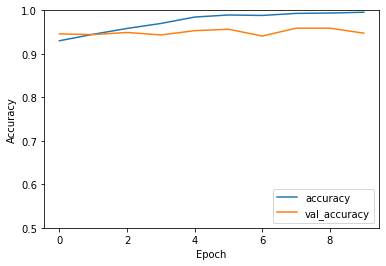

In [5]:
plt.plot(history_cnn.history['accuracy'], label='accuracy')
plt.plot(history_cnn.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()



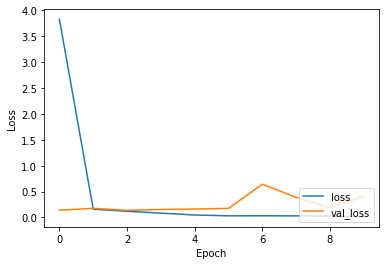

In [6]:
plt.plot(history_cnn.history['loss'], label='loss')
plt.plot(history_cnn.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

In [7]:
test_loss, test_acc, test_recall = model.evaluate(X_val,  y_val, verbose=2, batch_size=4)

305/305 - 3s - loss: 0.4043 - accuracy: 0.9475 - recall: 0.6301 - 3s/epoch - 10ms/step


In [14]:
predictions = (model.predict(X_val, batch_size=4)>0.5).reshape(1,-1)[0].astype(int)
# predictions = model.predict(X_val, batch_size=10)
# class_predictions = np.argmax(predictions,axis=1)
real_values = y_val.T[0]

print(predictions)
print(real_values)

305/305 [==============================] - 3s 9ms/step
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]


In [8]:
test_loss, test_acc, test_recall = model.evaluate(X_test,  y_test, verbose=2, batch_size=4)

654/654 - 6s - loss: 0.3977 - accuracy: 0.9350 - recall: 0.4430 - 6s/epoch - 10ms/step


In [15]:
predictions = (model.predict(X_test, batch_size=4)>0.5).reshape(1,-1)[0].astype(int)
# predictions = model.predict(X_val, batch_size=10)
real_values = y_test.T[0]

print(predictions)
print(real_values)

654/654 [==============================] - 6s 9ms/step
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


In [16]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(real_values, predictions)

0.4171480707541146

# Resnet Model

In [3]:
# Transfer Learning
base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(1, activation="sigmoid")(avg)

model = tf.keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False # Esto impide que las capas se re entrenen

2022-09-28 14:13:04.836284: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-28 14:13:04.919881: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-28 14:13:04.920007: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-28 14:13:04.920457: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [4]:
X_train_rgb = np.repeat(X_train, 3, -1)
X_val_rgb = np.repeat(X_val, 3, -1)

del X_train
del X_val

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience = 7)

checkpoint_path='Resnet50-model.ckpt'
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.compile(loss = 'bce', optimizer = 'adam', metrics=['accuracy', tf.keras.metrics.Recall()])
history_cnn = model.fit(X_train_rgb, y_train, epochs=100, 
                        validation_data=(X_val_rgb, y_val),
                        batch_size=1,
                        callbacks=[early_stopping, cp_callback])

Epoch 1/100


2022-09-28 14:13:27.728563: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8300


   1/4878 [..............................] - ETA: 5:24:36 - loss: 1.1050 - accuracy: 0.0000e+00 - recall: 0.0000e+00

2022-09-28 14:13:29.022958: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


4877/4878 [============================>.] - ETA: 0s - loss: 0.1760 - accuracy: 0.9420 - recall: 0.3163

In [8]:
test_loss, test_acc, test_recall = model.evaluate(X_val_rgb,  y_val, verbose=2, batch_size=10)

predictions = (model.predict(X_val_rgb, batch_size=4)>0.5).reshape(1,-1)[0].astype(int)
# predictions = model.predict(X_val, batch_size=10)
# class_predictions = np.argmax(predictions,axis=1)
real_values = y_val.T[0]

print(predictions)
print(real_values)

10/10 - 0s - loss: 0.3911 - accuracy: 0.9200 - recall_1: 0.2500 - 269ms/epoch - 27ms/step
25/25 [==============================] - 0s 13ms/step
[0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]


In [11]:
del X_train_rgb
del X_val_rgb

X_test_rgb = np.repeat(X_test[0:100], 3, -1)
y_test = y_test[:100]
del X_test

test_loss, test_acc, test_recall = model.evaluate(X_test_rgb,  y_test, verbose=2, batch_size=10)

predictions = (model.predict(X_test_rgb, batch_size=4)>0.5).reshape(1,-1)[0].astype(int)
# predictions = model.predict(X_val, batch_size=10)
real_values = y_test.T[0]

print(predictions)
print(real_values)

NameError: name 'X_train_rgb' is not defined

In [ ]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(real_values, predictions)